## Package Installation

In [ ]:
#pip install --upgrade gensim

In [ ]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

## Importing Necessary Packages

In [244]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

import nltk
import re
import xml.sax.saxutils
import itertools

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from gensim.utils import lemmatize

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

import datetime
import fasttext

## Uploading Training Dataset

In [245]:
def load():
    """
    Uploading Train Dataset
    """
    df = pd.read_csv("Train.csv",encoding='utf-8')
    print("Data not properly aligned: \n ")
    print(df.info(),"\n")
    
    #To properly align the data in their respective columns, we split the Dataframe
    table = df[pd.notna(df['Unnamed: 1'])].copy()

    #Splitting the first column
    df = df['tweet_id,sentiment,tweet_text'].str.split(",",2,expand=True) 
    print(df.info(),'\n')
    
    df.rename(columns= {0:"tweet_id",1:"sentiment",2:"tweet_text"},inplace=True)

    #Joining the remaining data columns
    for row in table.index:
        df.loc[row,"tweet_id"] = table.loc[row,'tweet_id,sentiment,tweet_text']
        df.loc[row,"sentiment"] = table.loc[row,'Unnamed: 1']
        df.loc[row,"tweet_text"] = table.loc[row,'Unnamed: 2']
        
    print("Data properly aligned in their respective columns: \n")
    print(df.info())
    return df

In [246]:
df = load()

Data not properly aligned: 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21630 entries, 0 to 21629
Data columns (total 3 columns):
tweet_id,sentiment,tweet_text    21630 non-null object
Unnamed: 1                       165 non-null object
Unnamed: 2                       165 non-null object
dtypes: object(3)
memory usage: 507.0+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21630 entries, 0 to 21629
Data columns (total 3 columns):
0    21630 non-null object
1    21465 non-null object
2    21465 non-null object
dtypes: object(3)
memory usage: 507.0+ KB
None 

Data properly aligned in their respective columns: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21630 entries, 0 to 21629
Data columns (total 3 columns):
tweet_id      21630 non-null object
sentiment     21630 non-null object
tweet_text    21630 non-null object
dtypes: object(3)
memory usage: 507.0+ KB
None


In [247]:
df['sentiment'].value_counts()

positive    9155
neutral     9075
negative    3400
Name: sentiment, dtype: int64

## Data Pre-processing

In [248]:
def contraction_map():
    return { "ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who'd" : "who would",
"who's": "who is",
"who're" : "who are",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
 "'re": " are",  }

In [249]:
def emoticon():
    return {':‑)': 'happy',':-]': 'happy', ':-3': 'happy',':->': 'happy','8-)': 'happy',':-}': 'happy', ':)': 'happy',
 ':]': 'happy', ':3': 'happy', ':>': 'happy', '8)': 'happy', ':}': 'happy', ':o)': 'happy', ':c)': 'happy', ':^)': 'happy',
 '=]': 'happy', '=)': 'happy', ':-))': 'happy', ':‑D': 'happy', '8‑D': 'happy', 'x‑D': 'happy', 'X‑D': 'happy', ':D': 'happy',
'8D': 'happy', 'xD': 'happy', 'XD': 'happy', ':‑(': 'sad', ':‑c': 'sad', ':‑<': 'sad', ':‑[': 'sad', ':(': 'sad', ':c': 'sad',
 ':<': 'sad', ':[': 'sad', ':-||': 'sad', '>:[': 'sad', ':{': 'sad', ':@': 'sad', '>:(': 'sad', ":'‑(": 'sad', ":'(": 'sad',
':‑P': 'playful', 'X‑P': 'playful', 'x‑p': 'playful', ':‑p': 'playful', ':‑Þ': 'playful', ':‑þ': 'playful', ':‑b': 'playful',
 ':P': 'playful', 'XP': 'playful', 'xp': 'playful', ':p': 'playful', ':Þ': 'playful', ':þ': 'playful', ':b': 'playful',
 '<3': 'love', '><': 'sad', '>.<': 'sad', '>_<': 'sad', ':*': 'happy', ')-:': 'sad', '-____-': 'sad', '.\\_/.!': 'anger',
 '*\\o/*': 'playful', '-______-': 'sad', ';__;': 'sad', ':O)': 'happy', 'meh': 'sad', ':-\\': 'sad', ':--(': 'sad', 
 ',)': 'happy', ';o': 'playful', ';p': 'playful', ';P': 'playful', ';]': 'happy', ';b': 'playful', ';O': 'playful',
';D': 'happy', ';>': 'happy', ';;': 'sad', ';3': 'happy', '^___^': 'happy', ';/': 'sad', ';*': 'happy', ';)': 'happy',
':|': 'sad',':o': 'playful',':\\': 'sad',':S': 'sad',':O': 'playful',':L': 'happy',':/': 'sad', ').': 'sad',
')-': 'sad', '(@': 'happy','(:': 'happy','(;': 'happy','*.*': 'happy','*0*': 'happy',
'-.-': 'sad','-_-': 'sad', '.-.': 'sad','._.': 'sad', ":')": 'happy',':**': 'sad', ':-(': 'sad',
':-)': 'happy', ':-/': 'sad', ':-D': 'happy', ':-O': 'playful',':-P': 'playful', ':-o': 'playful', 
':.(': 'sad','^^': 'happy','^.^': 'happy', '^-^': 'happy','\m/': 'playful','>_>': 'sad','>=)': 'happy', '>:|': 'sad',
'>:)': 'happy', '>3<': 'sad', '>.>': 'happy', '=D': 'happy', '=.=': 'anger', '</3': 'hate',';w;': 'sad','://': 'sad',
':0)': 'happy',':v': 'playful',';-)': 'happy', ';-;': 'sad',';0(': 'sad',';@)': 'happy',';_;': 'sad', '=))': 'happy'}

In [250]:
def cleaning_function(tweets):
    """
    Input : tweets , a list with strings as elements with unicodes,html entities,apostrophes,punctuation,words,emoticons,etc
    
    Output : cln, a list with strings as elements cleaned from unnecessary characters.
    """
    cln = []
    CONTRACTION_MAP = contraction_map()
    
    def emotics(line):
        emoticons = emoticon()
        for i in emoticons.keys():
            if i in line:
                line = line.replace(i,emoticons[i])
        return line
    
    for i in range(len(tweets)):
        
        # A : removing html entities like &lt; &gt; &amp;
        A = xml.sax.saxutils.unescape(tweets[i])
        
        # B : Removing @ tagged words and # tags
        B = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", A).split())
        
        # C : Removing http  and www links
        C_ = ' '.join(re.sub("(\w+:\/\/\S+)", " ", B).split())
        C = " ".join(filter(lambda x:x[0:4]!='www.',C_.split()))
        
        # D:  Replacing respective unicodes and hashes + Lower-casing
        D1 = C.replace('\\u2019',"'")
        D2 = D1.replace('\\u002c',',')
        D = D2.lower()
        
        # E : standardizing words
        E =''.join(''.join(s)[:2] for _, s in itertools.groupby(D))
        
        # F : correcting words with apostrophes 
        words = E.split()
        F = [CONTRACTION_MAP[word] if word in CONTRACTION_MAP else word for word in words]
        
        # G : Removing emoticons
        G = emotics(" ".join(F))
        
        # H : to remove punctuations
        cln.append(re.sub('[^A-Za-z0-9]+', ' ', G))
        
    return cln

In [251]:
def Lemmatize_(tweets):
    """
    Input : tweets, list of sentences to be lemmatized
    
    Output : cleaned, list containing elements of lemmatized words with POS tagging
    """
    cleaned = []
    
    for i in range(len(tweets)):
        
        #Lemmatization
        try:
            lemm = lemmatize(tweets[i].encode())
        except StopIteration:
            return
        
        cleaned.append([lemm[i].decode("utf-8-sig") for i in range(len(lemm))])
        
    return cleaned

In [252]:
def separate_word_tag(df_lem_test):
    """
    Input : df_lem_test, list containing elements of lemmatized words with POS tagging
    
    Output : df, Dataframe with two columns: lem_words , lem_tag
    """
    words=[]
    types=[]
    df= pd.DataFrame()
    for row in df_lem_test:
        sent = []
        type_ =[]
        for word in row:
            split = word.split('/')
            sent.append(split[0])
            type_.append(split[1])
        words.append(' '.join(word for word in sent))
        types.append(' '.join(word for word in type_))
    df['lem_words']= words
    df['lem_tag']= types
    return df

In [253]:
def data_preprocessing(df):
    """
    Input : df, Dataframe to be pre-processed.
    
    Output : df_training, pre-processed Dataframe.
    """
    tweets = cleaning_function(df.tweet_text.copy())
    
    #Run this function call multiple times to silence the exception - RuntimeError: generator raised StopIteration 
    # Problem may exist in Python 3.6 & above

    word_tag = Lemmatize_(tweets)
    lemm_df = separate_word_tag(word_tag)
    
    # concat cleaned text with original
    df_training = pd.concat([df, lemm_df], axis=1)
    df_training['word_tags'] = word_tag
    
    # reset index just to be safe
    df_training = df_training.reset_index(drop=True)

    print("Checking null values :")
    print(df_training.isnull().sum())

    print('Checking empty values :')
    print(df_training[df_training['lem_words']==''])
    
    print('\n')
    print(df.sentiment.value_counts())
    sns.countplot(x="sentiment", data=df_training)
    print('UNBALANCED DATA!!!')
    
    # convert to numeric values
    df_training['sentiment'] = df_training.sentiment.map(lambda x: int(2) if x =='positive' else int(0) if x =='negative' 
                                                         else int(1) if x == 'neutral' else np.nan)
    return df_training

Checking null values :
tweet_id      0
sentiment     0
tweet_text    0
lem_words     0
lem_tag       0
word_tags     0
dtype: int64
Checking empty values :
Empty DataFrame
Columns: [tweet_id, sentiment, tweet_text, lem_words, lem_tag, word_tags]
Index: []


positive    9155
neutral     9075
negative    3400
Name: sentiment, dtype: int64
UNBALANCED DATA!!!


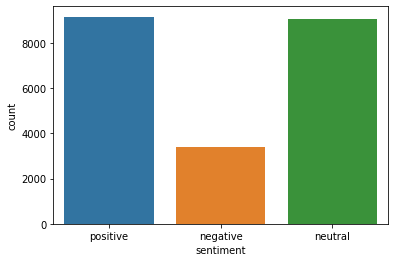

In [254]:
#Run this cell multiple times to silence the exception - RuntimeError: generator raised StopIteration 
# Problem may exist in Python 3.6 & above

df_training = data_preprocessing(df)

## Train Test Split & Bootstrapping

In [289]:
def train_test_splitting(df_training,training_csv,testing_csv):
    """
    Input : df_training, a csv file which is to be split into training_bs and testing file in ratio 7:3 and saved into the current directory.
        
    Output : 1, for successful saving of files in to the directory.
    
    """ 
    train, test = train_test_split(df_training, test_size=0.3, random_state=1)
    
    #Bootstrapping
    t_1 = train[train['sentiment']==1].sample(20000,replace=True)
    t_2 = train[train['sentiment']==2].sample(20000,replace=True)
    t_3 = train[train['sentiment']==0].sample(20000,replace=True)
    training_bs = pd.concat([t_1, t_2, t_3])

    print("Training data shape:" ,train.shape)
    print("Training data shape after Bootstrapping:" ,training_bs.shape)
    print("Test data shape:",test.shape)
    
    # sanity check 
    #df_training.shape[0] == (train.shape[0] + test.shape[0])
    
    print("Before bootstrapping")
    print(train['sentiment'].value_counts(normalize=True))
    baseline = 0.3

    print("\n")
    print("After Bootstrapping")
    print(training_bs['sentiment'].value_counts(normalize=True))
    baseline = 0.3
    sns.countplot(x="sentiment", data=training_bs)
    plt.show()
    
    # reset index before saving
    training_bs = training_bs.reset_index(drop=True)
    training_bs.to_csv(training_csv, header=True, index=False, encoding='UTF8')
    test = test.reset_index(drop=True)
    test.to_csv(testing_csv, header=True, index=False, encoding='UTF8')
    
    return 1

Training data shape: (15141, 6)
Training data shape after Bootstrapping: (60000, 6)
Test data shape: (6489, 6)
Before bootstrapping
1    0.424411
2    0.420118
0    0.155472
Name: sentiment, dtype: float64


After Bootstrapping
2    0.333333
1    0.333333
0    0.333333
Name: sentiment, dtype: float64


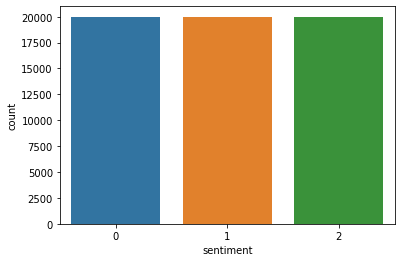

In [290]:
success = train_test_splitting(df_training,"training.csv","testing.csv")

## Word Cloud Representation of the Training Dataset

In [257]:
def word_cloud(csv_file):
    
    training_bs = pd.read_csv(csv_file)
    
    print("WORD CLOUD REPRESENTATION: ")

    print("Polarity == 0: negative")
    train_s0 = training_bs[training_bs.sentiment ==0]
    all_text = " ".join(word for word in train_s0.lem_words)
    wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

    print("Polarity == 1: neutral")
    train_s1 = training_bs[training_bs.sentiment ==1]
    all_text = ' '.join(word for word in train_s1.lem_words)
    wordcloud = WordCloud(width=1000, height=1000, colormap='Wistia', background_color='white', mode='RGBA').generate(all_text)
    plt.figure( figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

    print("Polarity == 2: positive")
    train_s2 = training_bs[training_bs.sentiment ==2]
    all_text = ' '.join(word for word in train_s2.lem_words)
    wordcloud_p2 = WordCloud(width=1000, height=1000, colormap='winter',background_color='white', mode='RGBA').generate(all_text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud_p2, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

WORD CLOUD REPRESENTATION: 
Polarity == 0: negative


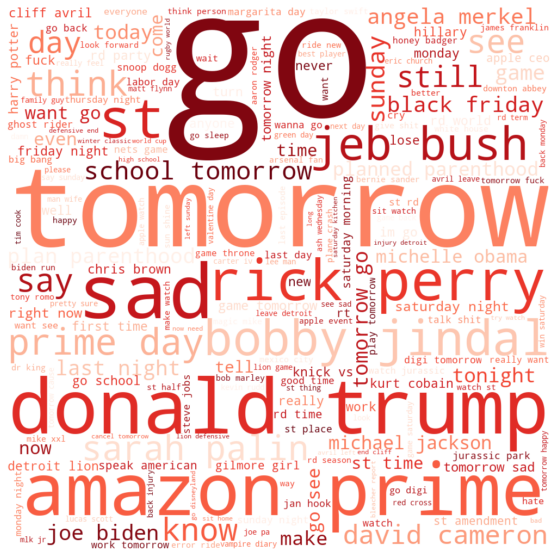

Polarity == 1: neutral


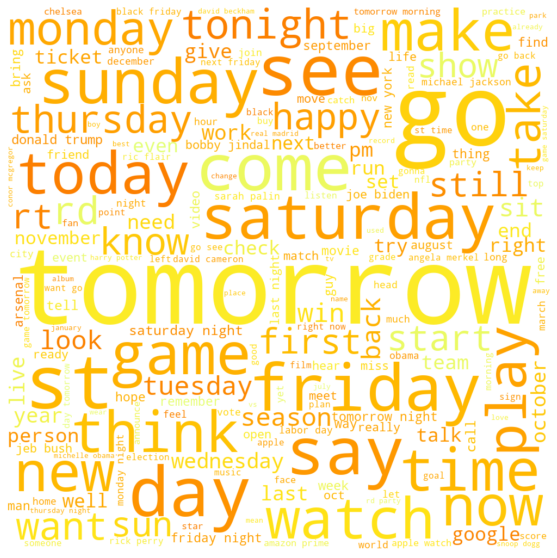

Polarity == 2: positive


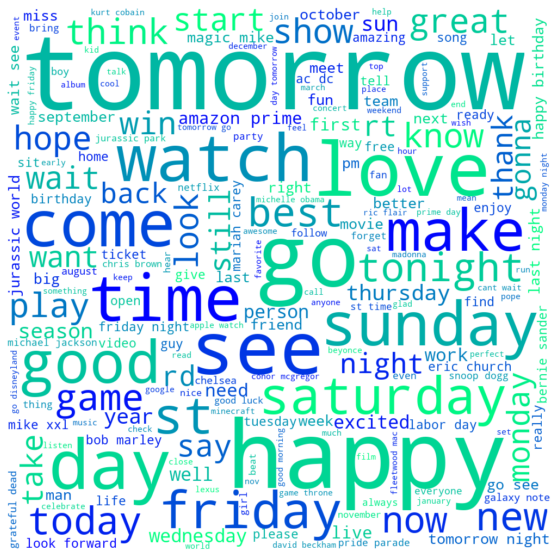

In [258]:
word_cloud("training_bs.csv")

## Frequency Distribution plot of first common 50 Words in Training Dataset

In [259]:
def freq_dist_plot(csv_file):
    """
    Frequency Distribution Plot of words in the training dataset (csv_file)

    """
    training = pd.read_csv(csv_file)
    X_train = training['lem_words']
    doc = " ".join([i for i in X_train])
    fdist = FreqDist(word_tokenize(doc))
    print(fdist)
    
    # Frequency Distribution Plot
    plt.figure(figsize=(10,5))
    fdist.plot(50, cumulative=False)
    plt.show()


<FreqDist with 15166 samples and 351628 outcomes>


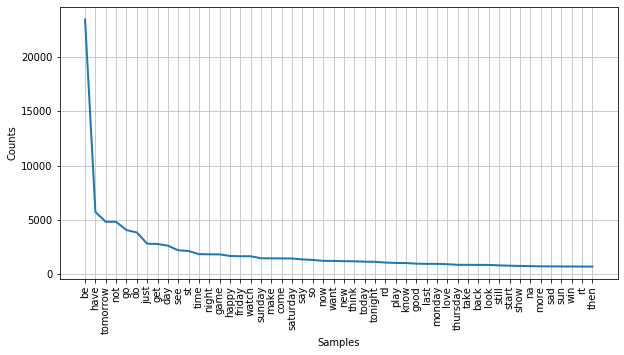

In [260]:
freq_dist_plot('training_bs.csv')

## Training the model - Feature Extraction

In [261]:
def best_feature_extraction(file):
    """
    Input : file, a csv file which is to be used for training the model 
            (Feature Extraction is done with the use of Tf-idf Vectorizer and Count Vectorizer.)
    
            
    Output : X_train, list 
             y_train, list
             a str, name of the Vectorizer function which gives the best score.
    
    """
    training = pd.read_csv(file, encoding='utf8')
    
    #set up X and y
    X_train = training['lem_words']
    y_train = training['sentiment']

    #Feature Extraction
    lr = LogisticRegression(random_state=1,solver = 'liblinear',multi_class='auto') #Initial Simple Classifier to check the model
    
    ##"Tf-idf Vectorizer"
    # initalise the vectoriser 
    tvec = TfidfVectorizer()
    # fit the training data on the model
    tvec.fit(X_train,y_train)
    #transform training data into sparse matrix
    X_train_tvec = tvec.transform(X_train)
    # cross val score/ predict
    tvec_score = cross_val_score(lr, X_train_tvec, y_train, cv=3)
    
    
    ## Count Vectorizer
    # initalise the vectoriser 
    cvec = CountVectorizer()
    # fit the training data on the model
    cvec.fit(X_train,y_train)
    #transform training data into sparse matrix
    X_train_cvec = cvec.transform(X_train)
    # cross val score/ predict
    cvec_score = cross_val_score(lr, X_train_cvec, y_train, cv=3 )
    
    # Term Frequency
    neg_doc_matrix = cvec.transform(X_train[y_train == 0])
    neu_doc_matrix = cvec.transform(X_train[y_train == 1])
    pos_doc_matrix = cvec.transform(X_train[y_train == 2])

    neg_tf = np.sum(neg_doc_matrix,axis=0)
    neu_tf = np.sum(neu_doc_matrix,axis=0)
    pos_tf = np.sum(pos_doc_matrix,axis=0)

    neg = np.squeeze(np.asarray(neg_tf))
    neu = np.squeeze(np.asarray(neu_tf))
    pos = np.squeeze(np.asarray(pos_tf))

    term_freq_df = pd.DataFrame([neg,neu,pos],columns=cvec.get_feature_names()).transpose()
    
    print("Negative Sentiment Class Top 10 common Words:")
    print("-"*50)
    print(term_freq_df.nlargest(10,[0])[0])

    print("\n")
    print("Neutral Sentiment Class Top 10 common Words:")
    print("-"*50)
    print(term_freq_df.nlargest(10,[1])[1])

    print("\n")
    print("Positive Sentiment Class Top 10 common Words:")
    print("-"*50)
    print(term_freq_df.nlargest(10,[2])[2])
    
    print('\n')
    print('Count Vectorizer Score:', cvec_score.mean())
    print('Tfidf Vectorizer Score:', tvec_score.mean())
    print('\n')

    acc_list = []
    acc_list.append(cvec_score.mean())
    acc_list.append(tvec_score.mean())

    # DataFrame Accuracy 
    acc_df = pd.DataFrame()
    acc_df['params']= ['cvec', 'tvec']
    acc_df['scores']= acc_list
    print(acc_df) 
    
    vector = np.argmax(np.array(acc_df.scores))
    if vector == 0:
        print("\nCount Vectorizer is the best vectorizer!")
        best =  acc_df.iloc[:1,:]
    else:
        print("\nTf-idf Vectorizer is the best vectorizer!")
        best =  acc_df.iloc[1:,:]
        
    return X_train,y_train,best

In [262]:
X_train, y_train, best_vector = best_feature_extraction('training_bs.csv')

Negative Sentiment Class Top 10 common Words:
--------------------------------------------------
be          9287
not         2794
have        2255
do          1805
tomorrow    1482
go          1435
just        1099
get         1054
st           795
day          761
Name: 0, dtype: int64


Neutral Sentiment Class Top 10 common Words:
--------------------------------------------------
be          6543
have        1732
tomorrow    1505
go          1259
do          1148
not         1067
get          821
day          801
just         794
st           707
Name: 1, dtype: int64


Positive Sentiment Class Top 10 common Words:
--------------------------------------------------
be          7615
tomorrow    1836
have        1739
go          1367
happy       1211
day         1059
see         1056
not          956
just         914
get          905
Name: 2, dtype: int64


Count Vectorizer Score: 0.8417996168743049
Tfidf Vectorizer Score: 0.7793325623304183


  params    scores
0   cvec  0.841800
1 

## Hyper-Parameter Tuning

In [263]:
print(best_vector)

  params  scores
0   cvec  0.8418


#### Count Vectorizer gives more score than other so we try to tune its parameters:


In [264]:
def hyper_parameter_tuning_cvec(X_train,y_train):
    """
    Output : Returns a dictionary of values for hyper-parameters for cvec
    """
    
    lr = LogisticRegression(random_state=1,solver = 'liblinear',multi_class='auto')
    
    #ngrams
    def count_vec_ngram(params, X_train, y_train):
        
        cvec_p = CountVectorizer(ngram_range=(params))
        cvec_p.fit(X_train)
        X_train_cvec_p = cvec_p.transform(X_train)
        # cross val score/ predict
        cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
        # cross validation 
        return cvec_score_p.mean()
    
    params = [(1,1), (1,2),(1,3), (1,4), (1,5)] 
    ngram_scores = []
    for p in params:
        ngram_scores.append(count_vec_ngram(p, X_train, y_train))
    
    ngrams = ['cvec gram_1','cvec gram_2','cvec gram_3','cvec gram_4','cvec gram_5']
    ngram_df = pd.DataFrame({'params':ngrams, 'scores':ngram_scores}, index=[0,1,2,3,4])
    # adding cvec score with default params
    ngram_df = ngram_df.append(best_vector)
    # plot scores on graph
    sns.pointplot(x='params', y='scores', data =ngram_df)
    plt.ylabel('Accuracy Score')
    plt.xlabel('ngrams')
    plt.xticks(rotation=40)
    plt.show()
    
    best_ngrams = params[np.argmax(ngram_scores)]
    
    # Maximum Features
    def count_vec_max_features(params, X_train, y_train):
        cvec_p = CountVectorizer(max_features=params)
        cvec_p.fit(X_train)
        X_train_cvec_p = cvec_p.transform(X_train)
        cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
        return cvec_score_p.mean()

    mf_params = [None, 1000, 5000, 10000, 15000]
    max_features_scores = [count_vec_max_features(p, X_train, y_train) for p in mf_params]
    max_features = ['max_f_'+str(p) for p in mf_params]
    # dataframe for scores
    max_features_df = pd.DataFrame({'params':max_features, 'scores':max_features_scores}, index=[0,1,2,3,4])
    # adding cvec score with default params
    max_features_df = max_features_df.append(best_vector)
    sns.pointplot(x='params', y='scores', data =max_features_df)
    plt.ylabel('Accuracy Score')
    plt.xlabel('Max Features')
    plt.xticks(rotation=40)
    plt.title('Accuracy of Max Features')
    plt.show()
    
    best_mf = mf_params[np.argmax(max_features_scores)]
    
    # Max document Frequency
    def count_vec_max_df(params, X_train, y_train):
        cvec_p = CountVectorizer(ngram_range = best_ngrams,max_df=params)
        cvec_p.fit(X_train)
        X_train_cvec_p = cvec_p.transform(X_train)
        cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
        return cvec_score_p.mean()

    mdf_params = [ 0.05, 0.15,0.25, 0.5, 0.75, 1.0]
    max_df_scores = [count_vec_max_df(p, X_train, y_train) for p in mdf_params]
    max_df = ['max_df_'+str(p) for p in mdf_params]
    max_df_df = pd.DataFrame({'params':max_df, 'scores':max_df_scores}, index=[0,1,2,3,4,5])
    max_df_df = max_df_df.append(best_vector)
    sns.pointplot(x='params', y='scores', data =max_df_df)
    plt.ylabel('Accuracy Score')
    plt.xlabel('max_df')
    plt.xticks(rotation=40)
    plt.title('Accuracy of Max df')
    plt.show()
 
    best_mdf = mdf_params[np.argmax(max_df_scores)]
    
    hyper_parameters = {}
    hyper_parameters['ngram_range'] = best_ngrams
    hyper_parameters['max_features'] = best_mf
    hyper_parameters['max_df'] = best_mdf
    
    print("Tuned Hyper_parameters: " ,hyper_parameters)
    
    return hyper_parameters

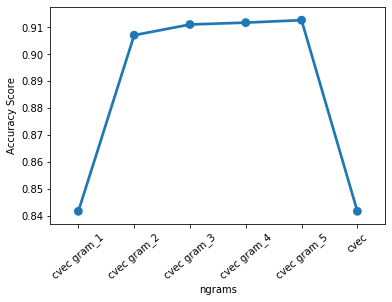

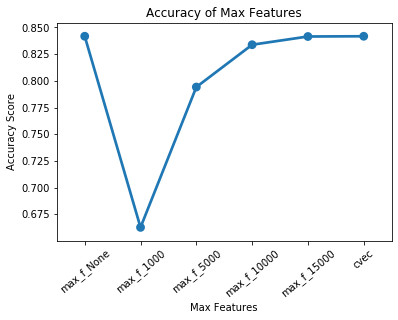

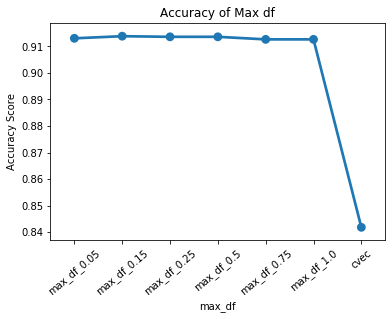

Tuned Hyper_parameters:  {'ngram_range': (1, 5), 'max_features': None, 'max_df': 0.15}


In [265]:
hyper_parameters = hyper_parameter_tuning_cvec(X_train,y_train)

## Tuned Count Vectorizer

In [266]:
def tuned_countvectorizer(X_train,y_train,hyper_parameters):
    ##### Count Vectorizer with tuned parameters
    # initalise the vectoriser 
    cvec = CountVectorizer(**hyper_parameters)
    # fit the training data on the model
    cvec.fit(X_train,y_train)
    
    return cvec

In [267]:
cvec= tuned_countvectorizer(X_train,y_train,hyper_parameters)

## Uploading Validation test file

In [268]:
def load_valid():
    testing = pd.read_csv('testing.csv', encoding='utf8')
     
    #set up X and y #Validation Set
    X_test = testing['lem_words']
    y_test = testing['sentiment']
    
    return X_test,y_test

In [269]:
X_test,y_test = load_valid()

## Finding the Best Classifier : Full model

### Testing with different classifiers to create The final Model

In [270]:
def best_model_with_classifier(cvec,X_train,y_train,X_test,y_test,):
    """
    Creating models with different classifiers ,the tuned Count Vectorizer and the training dataset
    and tests the model with the validation test dataset
    Output : model , with the classifier with best f1-score.
    """
    #transform training data into sparse matrix
    X_train_cvec = cvec.transform(X_train)
    X_test_cvec = cvec.transform(X_test)
    
    #Logistic Regression
    lr = LogisticRegression(random_state=1,solver = 'liblinear',multi_class='auto') #simple Logistic regression
    lr.fit(X_train_cvec, y_train)
    lr_pred = lr.predict(X_test_cvec)
    lr_score = metrics.f1_score(y_test, lr_pred, average='macro')
    
    # Logistic regression CrossValidation estimator fit with l1 regularisation
    lrcv_l1 = LogisticRegressionCV(Cs=np.logspace(-10,10,21),penalty = 'l1',solver='liblinear',cv=3,multi_class='auto') 
    lrcv_l1.fit(X_train_cvec, y_train)
    lrcv1_pred = lrcv_l1.predict(X_test_cvec)
    lrcv1_score = metrics.f1_score(y_test, lrcv1_pred, average='macro')
    
    # Logistic regression CrossValidation estimator fit with l1 regularisation
    lrcv_l2 = LogisticRegressionCV(Cs=np.logspace(-10,10,21), penalty = 'l2',solver='liblinear',cv=3, multi_class='auto') 
    lrcv_l2.fit(X_train_cvec, y_train)
    lrcv2_pred = lrcv_l2.predict(X_test_cvec)
    lrcv2_score = metrics.f1_score(y_test, lrcv2_pred, average='macro')
    
    #Stochastic Gradient Descent with Logistic Regression Classifier
    sgd = SGDClassifier(loss="log", penalty="none", max_iter = 100, tol = None)
    sgd.fit(X_train_cvec, y_train)
    sgd_pred = sgd.predict(X_test_cvec)
    sgd_score = metrics.f1_score(y_test, sgd_pred, average='macro')
    
    #Naive Bayes Classifier
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train_cvec, y_train)
    nb_pred = nb_clf.predict(X_test_cvec)
    nb_score = metrics.f1_score(y_test, nb_pred, average='macro')

    #Stochastic Gradient Descent with Hinge and L2 regularisation.
    #(Hinge (soft-margin): equivalent to Support Vector Classification L(y_i, f(x_i)) = max(0, 1 - y_i f(x_i)) )
    svm_clf = SGDClassifier(loss="hinge", penalty='l2', max_iter = 100, tol = None)
    svm_clf.fit(X_train_cvec, y_train)
    svm_pred = svm_clf.predict(X_test_cvec)
    svm_score = metrics.f1_score(y_test, svm_pred, average='macro')
    
    print('Logistic regression:', lr_score)
    print('Logistic regression CrossValidation estimator fit with l1 regularisation:', lrcv1_score)
    print('Logistic regression CrossValidation estimator fit with l2 regularisation:', lrcv2_score)
    print('Stochastic Gradient Descent with Logistic Regression Classifier:',sgd_score)
    print('Naive Bayes Classifier:',nb_score)
    print('Stochastic Gradient Descent with Hinge and L2 regularisation:',svm_score)
    print("\n")
    
    acc_list = []
    acc_list.append(lr_score)
    acc_list.append(lrcv1_score)
    acc_list.append(lrcv2_score)
    acc_list.append(sgd_score)
    acc_list.append(nb_score)
    acc_list.append(svm_score)

    # DataFrame Score
    acc_df = pd.DataFrame()
    acc_df['params']= ['Logistic regression','Logistic regression CV with l1 ',
                   'Logistic regression CV with l2 ',
                  'Stochastic Gradient Descent + Logistic Classifier','Naive Bayes Classifier',
                   'Stochastic Gradient Descent + Hinge & L2 ']
    acc_df['scores']= acc_list
    print(acc_df)
    print("\n")
    
    model = 0
    index = np.argmax(np.array(acc_list))
    if index == 0:
        print(acc_df['params'][0],"!!! is the best classifier")
        model = lr
    elif index == 1:
        print(acc_df['params'][1],"!!! is the best classifier")
        model = lrcv_l1
    elif index == 2:
        print(acc_df['params'][2],"!!! is the best classifier")
        model = lrcv_l2
    elif index == 3:
        print(acc_df['params'][3],"!!! is the best classifier")
        model = sgd
    elif index == 4:
        print(acc_df['params'][4],"!!! is the best classifier")
        model = nb_clf
    else:
        print(acc_df['params'][5],"!!! is the best classifier")
        model = svm_clf
        
    return model

In [271]:
model = best_model_with_classifier(cvec,X_train,y_train,X_test,y_test)

C:\Users\DIVYA\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\DIVYA\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Logistic regression: 0.5984044498888964
Logistic regression CrossValidation estimator fit with l1 regularisation: 0.5617600127820565
Logistic regression CrossValidation estimator fit with l2 regularisation: 0.5926491078429518
Stochastic Gradient Descent with Logistic Regression Classifier: 0.5650189909017653
Naive Bayes Classifier: 0.5540894948070935
Stochastic Gradient Descent with Hinge and L2 regularisation: 0.5838879359270145


                                              params    scores
0                                Logistic regression  0.598404
1                    Logistic regression CV with l1   0.561760
2                    Logistic regression CV with l2   0.592649
3  Stochastic Gradient Descent + Logistic Classifier  0.565019
4                             Naive Bayes Classifier  0.554089
5          Stochastic Gradient Descent + Hinge & L2   0.583888


Logistic regression !!! is the best classifier


## Pre-process Test dataset 

In [272]:
#prediction data -- test samples
def Clean_predict_data(csv_file):
    """
    final_test csv is produced by pre-processing the given csv_file and saved in the current directory
    which will further help to predict sentiments.
    
    """
    data = pd.read_csv(csv_file)
    
    tweets =  cleaning_function(data.tweet_text.copy())
    
    word_tag_ = Lemmatize_(tweets)
    lemm_data = separate_word_tag(word_tag_)
    # concat cleaned text with original
    data_predict = pd.concat([data, lemm_data], axis=1)
    data_predict['word_tags'] = word_tag_

    # save clean file to csv
    data_predict.to_csv('final_test.csv', header=True, index=False, encoding='UTF8')

In [273]:
Clean_predict_data("test_samples.txt")

## Final Prediction of Sentiments for Test Dataset

In [274]:
def predicting_sentiments(csv_file,model,cvec):
    """
    Predicts sentiments [negaive,neutral,positive] with the given model and cvec vectorizer.
    A submission_ named csv file is saved in the current directory with the predicted sentiments.
    """
    #FINAL TEST SET
    test = pd.read_csv(csv_file)
    X_final_test = test['lem_words']
    X_final_test_cvec = cvec.transform(X_final_test)
    y_predict = model.predict(X_final_test_cvec)
    
    sentiment = []
    for i in range(len(y_predict)):
        if y_predict[i] == 0:
            sentiment.append('negative')
        elif y_predict[i] == 1:
            sentiment.append('neutral')
        else:
            sentiment.append('positive')
            
    d = pd.DataFrame()
    d['sentiment'] = sentiment
    predicted = pd.concat([test.tweet_id,d ], axis=1)
    
    predicted.to_csv('Submission_.csv', header=True, index=False, encoding='UTF8')

In [294]:
predicting_sentiments("final_test.csv ",model,cvec) 

# ANOTHER MODEL : FASTTEXT

In [276]:
ft = load()

Data not properly aligned: 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21630 entries, 0 to 21629
Data columns (total 3 columns):
tweet_id,sentiment,tweet_text    21630 non-null object
Unnamed: 1                       165 non-null object
Unnamed: 2                       165 non-null object
dtypes: object(3)
memory usage: 507.0+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21630 entries, 0 to 21629
Data columns (total 3 columns):
0    21630 non-null object
1    21465 non-null object
2    21465 non-null object
dtypes: object(3)
memory usage: 507.0+ KB
None 

Data properly aligned in their respective columns: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21630 entries, 0 to 21629
Data columns (total 3 columns):
tweet_id      21630 non-null object
sentiment     21630 non-null object
tweet_text    21630 non-null object
dtypes: object(3)
memory usage: 507.0+ KB
None


## Data Pre-processing for Fasttext model

In [277]:
def slang_():
    return {'2day': 'today',
 '2moro': 'tomorrow',
 '2nite': 'tonight',
 '4eae': 'for ever and ever',
 'abt': 'about',
 'adn': 'any day now',
 'afaic': 'as far as i am concerned',
 'afaict': 'as far as i can tell',
 'afaik': 'as far as i know',
 'afair': 'as far as i remember',
 'aka': 'also known as',
 'ama': 'ask me anything',
 'asaic': 'as soon as i can',
 'asap': 'as soon as possible',
 'atm': 'at the moment',
 'b4': 'before',
 'B4N': 'bye for now',
 'bae': 'babe',
 'bbl': 'be back later',
 'bbt': 'be back tomorrow',
 'bcnu': 'be seeing you',
 'bd': 'big deal',
 'bf': 'boy friend',
 'bff': 'best friends forever',
 'bmt': 'before my time',
 'bol': 'be on later',
 'bot': 'back on topic',
 'brb': 'be right back',
 'bro': 'brother',
 'bt': 'but',
 'btw': 'by the way',
 'cfy': 'calling for you',
 'cu': 'see you',
 'cul': 'see you later',
 'cuz': 'because',
 'cya': 'see you',
 'dae': 'does anyone else',
 'dba': 'doing business as',
 'dftba': 'don not forget to be awesome',
 'diku': 'do i know you',
 'dm': 'direct message',
 'dnd': 'do not disturb',
 'dr': 'double rainbow',
 'dwbh': 'do not worry be happy',
 'eli5': 'explain like i am five',
 'eom': 'end of message',
 'eos': 'end of story',
 'f2f': 'face to face',
 'faq': 'frequently asked question',
 'fb': 'facebook',
 'fbf': 'flash back friday',
 'ff': 'follow friday',
 'fify': 'fixed it for you',
 'fitb': 'fill in the blank',
 'fml': 'fuck my life',
 'fomo': 'fear of missing out',
 'ftfy': 'fixed that for you',
 'ftl': 'for the loss',
 'ftw': 'for the win',
 'fwb': 'friends with benefits',
 'fwiw': 'for what it’s worth',
 'fye': 'for your entertainment',
 'fyeo': 'for your eyes only',
 'fyi': 'for your information',
 'ga': 'go ahead',
 'gal': 'get a life',
 'gf': 'girl friend',
 'gm': 'good morning',
 'gn': 'good night',
 'gr8': 'great',
 'gtr': 'getting ready',
 'hand': 'have a nice day',
 'hb': 'hurry back',
 'hbd': 'happy birthday',
 'hbu': 'how about you',
 'hmb': 'hit be back',
 'hmu': 'hit me up',
 'hru': 'how are you',
 'hth': 'hope this helps',
 'iac': 'in any case',
 'ic': 'i see',
 'icymi': 'in case you missed it',
 'idc': 'i do not care',
 'idk': 'i do not know',
 'ig': 'i guess',
 'iirc': 'if i remember correctly',
 'ikr': 'i know right',
 'ily': 'i love you',
 'imho': 'in my humble opinion',
 'immd': 'it made my day',
 'imy': 'i miss you',
 'irl': 'in real life',
 'iso': 'in search of',
 'iu2u': 'it is up to you',
 'j4f': 'just for fun',
 'jam': 'just a minute',
 'jfy': 'just for you',
 'jic': 'just in case',
 'jk': 'just kidding',
 'jsyk': 'just so you know',
 'kk': 'okay',
 'l8': 'late',
 'l8r': 'later',
 'lma': 'leave me alone',
 'lmao': 'laughing my ass off',
 'lmbo': 'laughing my butt off',
 'lmk': 'let me know',
 'lol': 'laugh out loud',
 'ltns': 'long time no see',
 'lylas': 'love you like a sister',
 'm': 'male',
 'f': 'female',
 'm8': 'mate',
 'mp': 'my pleasure',
 'msm': 'mainstream media',
 'mu': 'miss you',
 'myob': 'mind your own business',
 'nagi': 'not a good idea',
 'nbd': 'no big deal',
 'ne1': 'anyone',
 'nm': 'not much',
 'np': 'no problem',
 'nsfl': 'not safe for life',
 'nsfw': 'not safe for work',
 'nts': 'note to self',
 'nvm': 'never mind',
 'oc': 'original content',
 'oh': 'overheard',
 'oic': 'oh i see',
 'omd': 'oh my damn',
 'omg': 'oh my goodness',
 'omw': 'on my way',
 'ot': 'off topic',
 'ofc': 'of course',
 'paw': 'parents are watching',
 'pls': 'please',
 'potd': 'photo of the day',
 'pov': 'point of view',
 'ppl': 'people',
 'ptb': 'please text back',
 'q4u': 'question for you',
 'qq': 'crying',
 'rbtl': 'read between the lines',
 'rip': 'rest in peace',
 'rl': 'real life',
 'rofl': 'rolling on the floor laughing',
 'rt': 'retweet',
 'rtm': 'read the manual',
 'sis': 'sister',
 'sitd': 'still in the dark',
 'sm': 'social media',
 'smh': 'shaking my head',
 'smy': 'somebody',
 'snh': 'sarcasm noted here',
 'sol': 'sooner or later',
 'some1': 'someone',
 'srsly': 'seriously',
 'stby': 'sucks to be you',
 'str8': 'straight',
 'sys': 'see you soon',
 'tba': 'to be announced',
 'tbh': 'to be honest',
 'tbt': 'truth be told',
 'tfh': 'thread from hell',
 'tfti': 'thanks for the invite',
 'tgif': 'thank god it’s friday',
 'thx': 'thanks',
 'tia': 'thanks in advance',
 'til': 'today i learned',
 'time': 'tears in my eyes',
 'tldr': 'too long did not read',
 'tlc': 'tender loving care',
 'tmi': 'too much information',
 'ttyl': 'talk to you later',
 'ttys': 'talk to you soon',
 'txt': 'text',
 'tyvm': 'thank you very much',
 'u': 'you',
 'u4f': 'you forever',
 'ur': 'your',
 'vbg': 'very big grin',
 'vsf': 'very sad face',
 'wb': 'welcome back',
 'wbu': 'what about you',
 'weg': 'wicked evil grin',
 'wknd': 'weekend',
 'wom': 'word of mouth',
 'wotd': 'word of the day',
 'wru': 'who are you',
 'wth': 'what the heck',
 'wtpa': 'where the party at',
 'wu': 'whats up',
 'wycm': 'will you call me',
 'wywh': 'wish you were here',
 'xoxo': 'hugs and kisses',
 'ygm': 'you have got mail',
 'ynk': 'you never know',
 'yolo': 'you only live once',
 'yt': 'youtube',
 'yw': 'you are welcome'}


In [278]:
def cleaning_function_fasttext(tweets):
    cln = []
    tokens = []
    word = []
    slang = slang_()
    CONTRACTION_MAP = contraction_map()
    
    def emotics(line):
        emoticons = emoticon()
        for i in emoticons.keys():
            if i in line:
                line = line.replace(i,emoticons[i])
        return line
    
    for i in range(len(tweets)):
        
        #removing html entities like &lt; &gt; &amp;
        tweets[i] = xml.sax.saxutils.unescape(tweets[i])
        
        #Removing @ tagged words and # tags
        tweets[i] = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", tweets[i]).split())
        
        #Removing http links
        tweets[i] = ' '.join(re.sub("(\w+:\/\/\S+)", " ", tweets[i]).split())
        tweets[i] = " ".join(filter(lambda x:x[0:4]!='www.',tweets[i].split()))
        
        # Replacing respective unicodes and hashes + Lower-casing
        tweets[i] = tweets[i].replace('\\u2019',"'")
        tweets[i] = tweets[i].replace('\\u002c',',')
        tweets[i] = tweets[i].lower()
        
        #standardizing words
        std = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweets[i]))
        
        #Removing emoticons
        no_emo=emotics(std)
        
        #correcting words with apostrophes 
        words = no_emo.split()
        ctd = [CONTRACTION_MAP[word] if word in CONTRACTION_MAP else word for word in words]
        ctd  = " ".join(ctd)
        
        # to remove punctuations
        t = ' '.join(re.sub("[\.\,\!\?\:\;\-\=\\\\""\(\)\~\/\'']", " ", no_emo).split())
        
        #internet slang removal
        slang_rem = t.split()
        s = [slang[word] if word in slang else word for word in slang_rem]
        
        
        tokens.append(word_tokenize(" ".join(s)))
    
        # remove all tokens that are not alphabetic
        word.append([j for j in tokens[i] if j.isalpha()])

        #Remove all the stand alone alphabets
        cln.append(" ".join([i for i in word[i] if len(i) > 1 or i.isupper()]))
        
    return cln


In [279]:
def Data_preprocessing_fasttext(df):
    
    tweets = cleaning_function_fasttext(df.tweet_text.copy())
    df_training = pd.concat([df[['tweet_id','sentiment']]], axis=1)
    df_training['tweets'] = tweets
    df_training = df_training.reset_index(drop=True)
    return df_training

In [280]:
df_training_fasttext = Data_preprocessing_fasttext(ft)

## Splitting Dataset as Training and Validation sets

In [291]:
def train_test_splitting_fasttext(df_training,training,validation):
    """
    df_training, a csv file which is to be split into training_bs and testing file in ratio 7:3 
    and saved into the current directory.
    """
    train, test = train_test_split(df_training, test_size=0.3, random_state=1)

    t_1 = train[train['sentiment']=='neutral'].sample(15000,replace=True)
    t_2 = train[train['sentiment']=='positive'].sample(15000,replace=True)
    t_3 = train[train['sentiment']=='negative'].sample(15000,replace=True)
    training_bs = pd.concat([t_1, t_2, t_3])

    print("Training Dataset Shape:", train.shape)
    print("Training Dataset Shape with Bootstrapping:" ,training_bs.shape)
    print("Validation set shape:",test.shape)
    
    data = pd.DataFrame()
    traini = []
    for i in range(training_bs.shape[0]):
        traini.append("__label__"+training_bs['sentiment'].iloc[i].upper()+" "+training_bs['tweets'].iloc[i])
    data['tweets']=traini
    
    data1 = pd.DataFrame()
    testi = []
    for i in range(test.shape[0]):
        testi.append("__label__"+training_bs['sentiment'].iloc[i].upper()+" "+training_bs['tweets'].iloc[i])
    data1['tweets']=testi
    
    np.savetxt(training, data.values,fmt='%s') #Training set
    np.savetxt(validation,data1.values,fmt='%s') #Validation set
    
    return 1

In [292]:
success = train_test_splitting_fasttext(df_training_fasttext,"fasttext_train.txt","fasttext_valid.txt")

Training Dataset Shape: (15141, 3)
Training Dataset Shape with Bootstrapping: (45000, 3)
Validation set shape: (6489, 3)


## Hyper-parameter Tuning for fasttext model

In [283]:
def hyper_parameter_tuning_ft(train,valid):
    
    model = fasttext.train_supervised(input=train)
    model_acc_training_set = model.test(train)
    model_acc_validation_set = model.test(valid)
    
    text_line = "accuracy:" + str(model_acc_training_set[1])  + ", validation:" + str(model_acc_validation_set[1]) + '\n' 
    print(text_line)
    
    acc_list = []
    acc_list.append(model_acc_validation_set[1])


    # DataFrame Accuracy 
    acc_df = pd.DataFrame()
    acc_df['params']= ['fasttext']
    acc_df['scores']= acc_list
    print(acc_df)
    
    def fasttext_word_ngrams(train, valid, params):
        model = fasttext.train_supervised(input=train, wordNgrams = params)
        # cross val score/ predict
        model_validation_set_score = model.test(valid)
        # cross validation 
        return model_validation_set_score[1]

    params = [ 0,1,2,3] 
    ngrams_scores = [fasttext_word_ngrams('fasttext_train.txt','fasttext_valid.txt', p) for p in params]
    ngrams = ['word_Ngrams_'+str(p) for p in params]
    ngrams_df = pd.DataFrame({'params':ngrams, 'scores':ngrams_scores}, index=[0,1,2,3])

    # adding fasttext score with default params
    ngrams_df = ngrams_df.append(acc_df.iloc[:1,:])

    # plot scores on graph
    sns.pointplot(x='params', y='scores', data =ngrams_df)
    plt.ylabel('Accuracy Score')
    plt.xlabel('word_Ngrams')
    plt.xticks(rotation=40)
    plt.show()
    
    best_ngram = params[np.argmax(ngrams_scores)]
    
    def fasttext_learning_rate(train, valid, params):
        model = fasttext.train_supervised(input=train,wordNgrams = best_ngram,lr = params)
        model_validation_set_score = model.test(valid)
        return model_validation_set_score[1]

    params = [ 0.0, 0.1, 0.2, 0.3, 0.4, 0.5] 
    lr_scores = [fasttext_learning_rate(train,valid, p) for p in params]   
    lr = ['Learning_rate_'+str(p) for p in params]
    lr_df = pd.DataFrame({'params':lr, 'scores':lr_scores}, index=[0,1,2,3,4,5])

    # adding fasttext score with default params
    lr_df = lr_df.append(acc_df.iloc[:1,:])

    # plot scores on graph
    sns.pointplot(x='params', y='scores', data =lr_df)
    plt.ylabel('Accuracy Score')
    plt.xlabel('Learning rates')
    plt.xticks(rotation=40)
    plt.show()
    
    best_lr = params[np.argmax(lr_scores)]
    
    def fasttext_epoch(train, valid, params):
        model = fasttext.train_supervised(input=train,lr = best_lr, epoch = params)
        # cross val score/ predict
        model_validation_set_score = model.test(valid)
        # cross validation 
        return model_validation_set_score[1]

    params = [500, 750, 1000, 1250, 1500] 
    epoch_scores = [fasttext_epoch('fasttext_train.txt','fasttext_valid.txt', p) for p in params]  
    epoch = ['Epochs_'+str(p) for p in params]
    epoch_df = pd.DataFrame({'params':epoch, 'scores':epoch_scores}, index=[0,1,2,3,4])

    # adding fasttext score with default params
    epoch_df = epoch_df.append(acc_df.iloc[:1,:])

    # plot scores on graph
    sns.pointplot(x='params', y='scores', data =epoch_df)
    plt.ylabel('Accuracy Score')
    plt.xlabel('Epochs')
    plt.xticks(rotation=40)
    plt.show()
    
    best_epoch = params[np.argmax(epoch_scores)]
    
    def fasttext_dim(train, valid, params):
        model = fasttext.train_supervised(input=train,dim = params)
        # cross val score/ predict
        model_validation_set_score = model.test(valid)
        # cross validation 
        return model_validation_set_score[1]

    params = [10, 15, 25, 35, 50] 
    dim_scores = [fasttext_dim('fasttext_train.txt','fasttext_valid.txt', p) for p in params]
    dim = ['Size_word_vectors_'+str(p) for p in params]
    dim_df = pd.DataFrame({'params':dim, 'scores':dim_scores}, index=[0,1,2,3,4])

    # adding fasttext score with default params
    dim_df = dim_df.append(acc_df.iloc[:1,:])

    # plot scores on graph
    sns.pointplot(x='params', y='scores', data = dim_df)
    plt.ylabel('Accuracy Score')
    plt.xlabel('Size_of_the_word_vectors')
    plt.xticks(rotation=40)
    plt.show()
    
    best_dim = params[np.argmax(dim_scores)]
    
    hyper_parameters = {}
    hyper_parameters['lr'] = best_lr
    hyper_parameters['epoch'] = best_epoch
    hyper_parameters['wordNgrams'] = best_ngram
    hyper_parameters['dim'] = best_dim
    
    print("Tuned Hyper_parameters: " ,hyper_parameters)
    
    return hyper_parameters

accuracy:0.9188333333333333, validation:0.7699183233163815

     params    scores
0  fasttext  0.769918


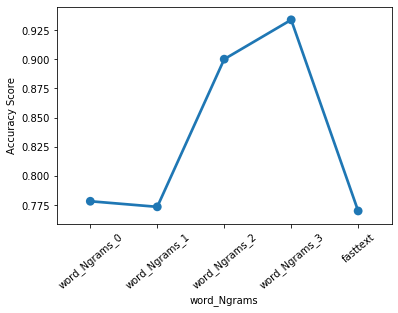

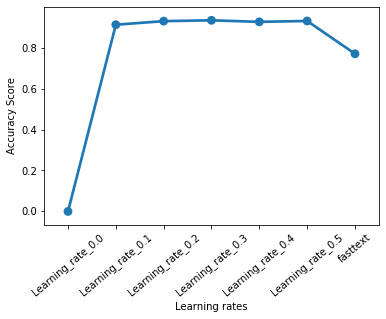

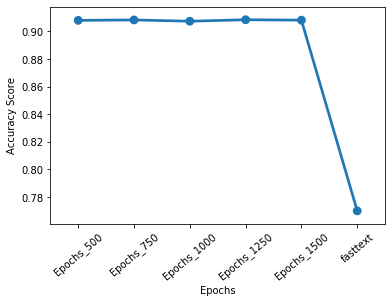

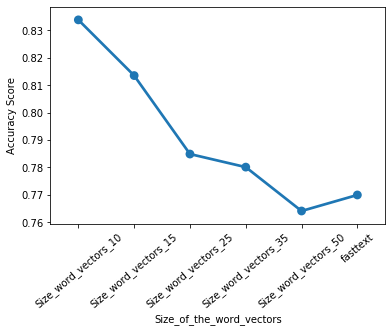

Tuned Hyper_parameters:  {'lr': 0.3, 'epoch': 1250, 'wordNgrams': 3, 'dim': 10}


In [284]:
hyper_parameters = hyper_parameter_tuning_ft("fasttext_train.txt","fasttext_valid.txt")

## Final fasttext model with tuned parameters

In [285]:
def final_fasttext_model(train, valid, hyper_parameters):
    """Training the model with tuned hyper-parameters"""
    fasttext_model = fasttext.train_supervised(input=train, **hyper_parameters)
    model_acc_training_set = fasttext_model.test(train)
    model_acc_validation_set = fasttext_model.test(valid)
        
    # DISPLAY ACCURACY OF TRAINED MODEL
    text_line = str(hyper_parameters) + " \n accuracy:" + str(model_acc_training_set[1])  + " \n validation:" + str(model_acc_validation_set[1]) + '\n' 
    print(text_line)
    return fasttext_model

In [286]:
fasttext_model = final_fasttext_model("fasttext_train.txt","fasttext_valid.txt",hyper_parameters)

{'lr': 0.3, 'epoch': 1250, 'wordNgrams': 3, 'dim': 10} 
 accuracy:0.9997666666666667 
 validation:0.9361997226074896



## Predicting Values through fasttext model for Test dataset

In [240]:
def predict_values(test,model):
    dat = pd.read_csv(test)
    tweets =  cleaning_function_fasttext(dat.tweet_text.copy())
    c = []
    for i in range(len(tweets)):
        a = model.predict(tweets[i],k=1)[0]
        if a[0] == '__label__NEGATIVE':
            c.append('negative')
        elif a[0] == '__label__POSITIVE':
            c.append('positive')
        elif a[0] == '__label__NEUTRAL':
            c.append('neutral')
    d = pd.DataFrame()
    d['sentiment']=c
    d.head()
    predicted = pd.concat([dat.tweet_id,d ], axis=1)
    predicted.to_csv('Submission_fasttext.csv', header=True, index=False, encoding='UTF8')

In [241]:
predict_values('test_samples.txt',fasttext_model)